In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
train_df_raw = pd.read_csv("../data/train.csv")
test_df_raw = pd.read_csv("../data/test.csv")

In [3]:
# View first five elements of train
train_df_raw.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Get the shape of train and test data
print(f"Train shape : {train_df_raw.shape}")
print(f"Test shape : {test_df_raw.shape}")

Train shape : (42000, 785)
Test shape : (28000, 784)


In [5]:
# Check missing data in train and test
print(f"Train missing data : {train_df_raw.isna().sum().sum()}")
print(f"Test missing data : {test_df_raw.isna().sum().sum()}")

Train missing data : 0
Test missing data : 0


In [6]:
# Visualize numbers
def show_digits(digits: pd.DataFrame, labels: pd.Series = None, ncols: int = 5) -> None:
    n = len(digits)
    nrows = n // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    axes = axes.ravel()
    for i in range(len(digits)):
        digit = np.reshape(digits.iloc[i], newshape=(28, 28))
        axes[i].imshow(digit, cmap="binary")
        if labels is not None:
            axes[i].set(title=f"Label: {labels.iloc[i]}")
        axes[i].set_xticks([]), axes[i].set_yticks([])
    plt.tick_params(top=False, bottom=False, left=False, right=False)
    plt.tight_layout() 

def sample_digits(df: pd.DataFrame, n: int = 10) -> pd.DataFrame:
    return df.sample(n)

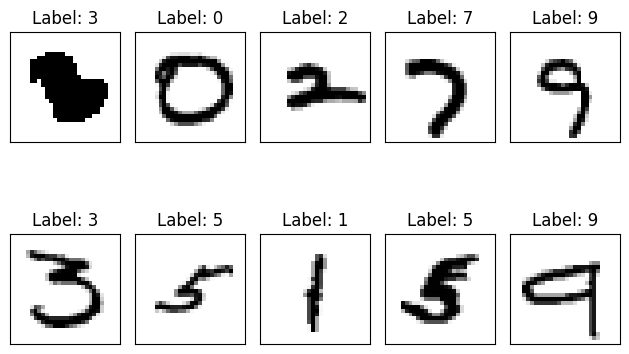

In [8]:
digits = sample_digits(train_df_raw)
digits, labels = digits.drop("label", axis=1), digits["label"]
show_digits(digits, labels)

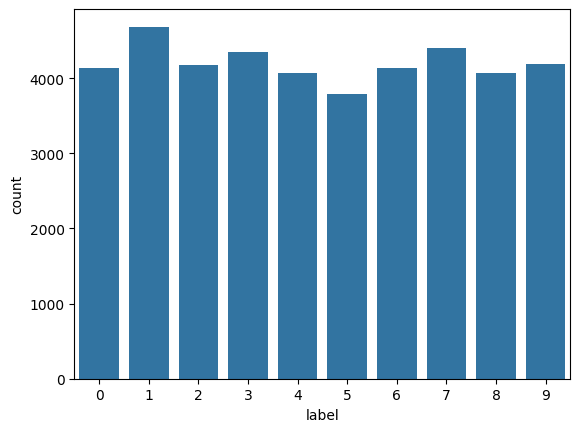

In [105]:
# Check distribution of numbers in the dataset
sns.countplot(train_df_raw, x="label");

## Data Preprocessing

In [38]:
def convert_digits(df: pd.DataFrame) -> np.ndarray:
    return df.to_numpy(dtype=np.float32).reshape(len(df), 28, 28, 1)

In [63]:
from sklearn.model_selection import train_test_split

# Split train data into features (X) and labels (y)
X_train, y_train = train_df_raw.drop("label", axis=1), train_df_raw["label"]

# Convert X to numpy arrays representing digits
X_train = convert_digits(X_train)

# Convert y to one-hot
y_train = pd.get_dummies(y_train, dtype=int).to_numpy()

# Scale X values to 0-1
X_train /= 255.0

# Check the shape of the sets
X_train.shape, y_train.shape

((42000, 28, 28, 1), (42000, 10))

In [64]:
# Convert test data into arrays
X_test = convert_digits(test_df_raw)

# Scale X_test values to 0-1
X_test /= 255.0

# Check the shape of the test set
X_test.shape

(28000, 28, 28, 1)

## Modelling

In [58]:
import tensorflow as tf
from tensorflow import keras

In [60]:
class EarlyStop(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs == None:
            logs == {}
        if logs.get("accuracy") > 0.99:
            print("Reached 99% accuracy, stopping training!")
            self.model.stop_training = True

In [112]:
# Baseline CNN model

# 1. Create model
model = keras.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

# 2. Compile model
model.compile(
    optimizer="adam",
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

# 3. Fit model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1, callbacks=[EarlyStop()])

Epoch 1/5
591/591 [==============================] - 9s 15ms/step - loss: 0.3151 - accuracy: 0.9022 - val_loss: 0.0891 - val_accuracy: 0.9717
Epoch 2/5
591/591 [==============================] - 9s 15ms/step - loss: 0.1178 - accuracy: 0.9642 - val_loss: 0.0731 - val_accuracy: 0.9781
Epoch 3/5
591/591 [==============================] - 9s 15ms/step - loss: 0.1007 - accuracy: 0.9694 - val_loss: 0.0708 - val_accuracy: 0.9790
Epoch 4/5
591/591 [==============================] - 9s 15ms/step - loss: 0.0992 - accuracy: 0.9723 - val_loss: 0.0661 - val_accuracy: 0.9810
Epoch 5/5
591/591 [==============================] - 9s 15ms/step - loss: 0.1261 - accuracy: 0.9711 - val_loss: 0.0970 - val_accuracy: 0.9788


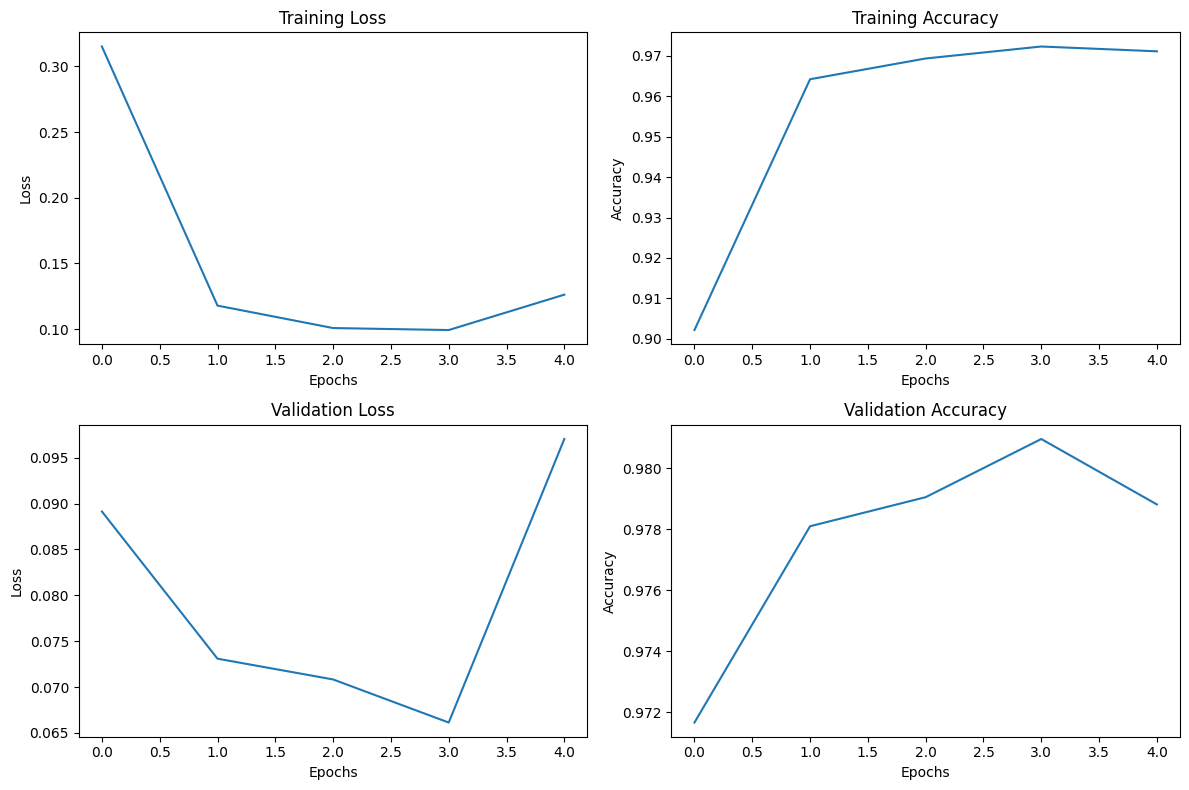

In [113]:
# Plot learning curve
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

axes[0,0].plot(history.history["loss"])
axes[0,0].set(title="Training Loss", xlabel="Epochs", ylabel="Loss")

axes[0,1].plot(history.history["accuracy"])
axes[0,1].set(title="Training Accuracy", xlabel="Epochs", ylabel="Accuracy")

axes[1,0].plot(history.history["val_loss"])
axes[1,0].set(title="Validation Loss", xlabel="Epochs", ylabel="Loss")

axes[1,1].plot(history.history["val_accuracy"])
axes[1,1].set(title="Validation Accuracy", xlabel="Epochs", ylabel="Accuracy")

plt.tight_layout()

In [91]:
# 4. Make predictions on X_test
y_pred = model.predict(X_test)

875/875 [==============================] - 3s 3ms/step


In [92]:
# Get the indices of the maximum predicted values
y_pred = y_pred.argmax(axis=-1)
y_pred

array([2, 0, 9, ..., 3, 9, 2])

In [96]:
# Save model
model_filepath = "../models/tf_mnist_model"
model.save(model_filepath)

INFO:tensorflow:Assets written to: ../models/tf_mnist_model/assets


INFO:tensorflow:Assets written to: ../models/tf_mnist_model/assets


In [104]:
# Make submission
submission = pd.DataFrame({"ImageId": test_df_raw.index + 1, "Label": y_pred})

submission_filepath = "../submissions/tf_mnist_model.csv"
submission.to_csv(submission_filepath, index=False)